# Chargement des données et nettoyage

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy import stats
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

arch15=pd.read_csv("archive/2015-building-energy-benchmarking.csv", sep=",")
arch16=pd.read_csv("archive/2016-building-energy-benchmarking.csv", sep=",")

In [2]:
print(arch15.shape)
print(arch16.shape)
arch15.sort_index(axis=1,inplace=True)
arch16.sort_index(axis=1,inplace=True)
print(len(arch15['OSEBuildingID'].unique()), len(arch16['OSEBuildingID'].unique())) 
# nombre d'ID uniques = nbe d'entrées donc pas de doublons

(3340, 47)
(3376, 46)
3340 3376


In [3]:
arch15[arch15['Comment'].isna()==False].to_csv(r'COMMENTS2015.csv')
# Sauvegarde de la colonne Commentaire dans un fichier séparé pour pouvoir s'y référer si besoin

In [4]:
# GHGEmissionIntensity = Emission des gaz à effet de serre
# Information qu'on voudra prédire donc uniformisation des noms de colonne entre les fichiers
arch15.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity'},inplace=True)
arch16.columns

# Création de liste des colonnes qui n'existent que dans un fichier et pas dans l'autre
notcommon=[]
for a,b in zip(arch15.columns.tolist(),arch16.columns.tolist()):
    if (b not in arch15.columns.tolist()): notcommon.append(b) 
    elif (a not in arch16.columns.tolist()): notcommon.append(a)

arch15.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity'},inplace=True)
arch16.columns

# Liste des colonnes communes entre les deux fichiers
common = set(arch15.columns.tolist()) & set(arch16.columns.tolist()) 
print(len(common),len(notcommon))

38 12


In [5]:
# Sélection des colonnes communes entre les deux fichiers et 'fusion' des deux fichiers
df1=arch15[common]
df2=arch16[common]

df_common=pd.concat([df1,df2]) #colonne DataYear pour séparer les années pr les mm bâtiments
len(df_common['OSEBuildingID'].unique()) # On 3432 ID uniques pour 6716 lignes 
                                         # (3358 serait la moitié des 6716 donc on a des buildings uniques sur 2015 / 2016)

3432

### Bar plot du taux de remplissage des variables

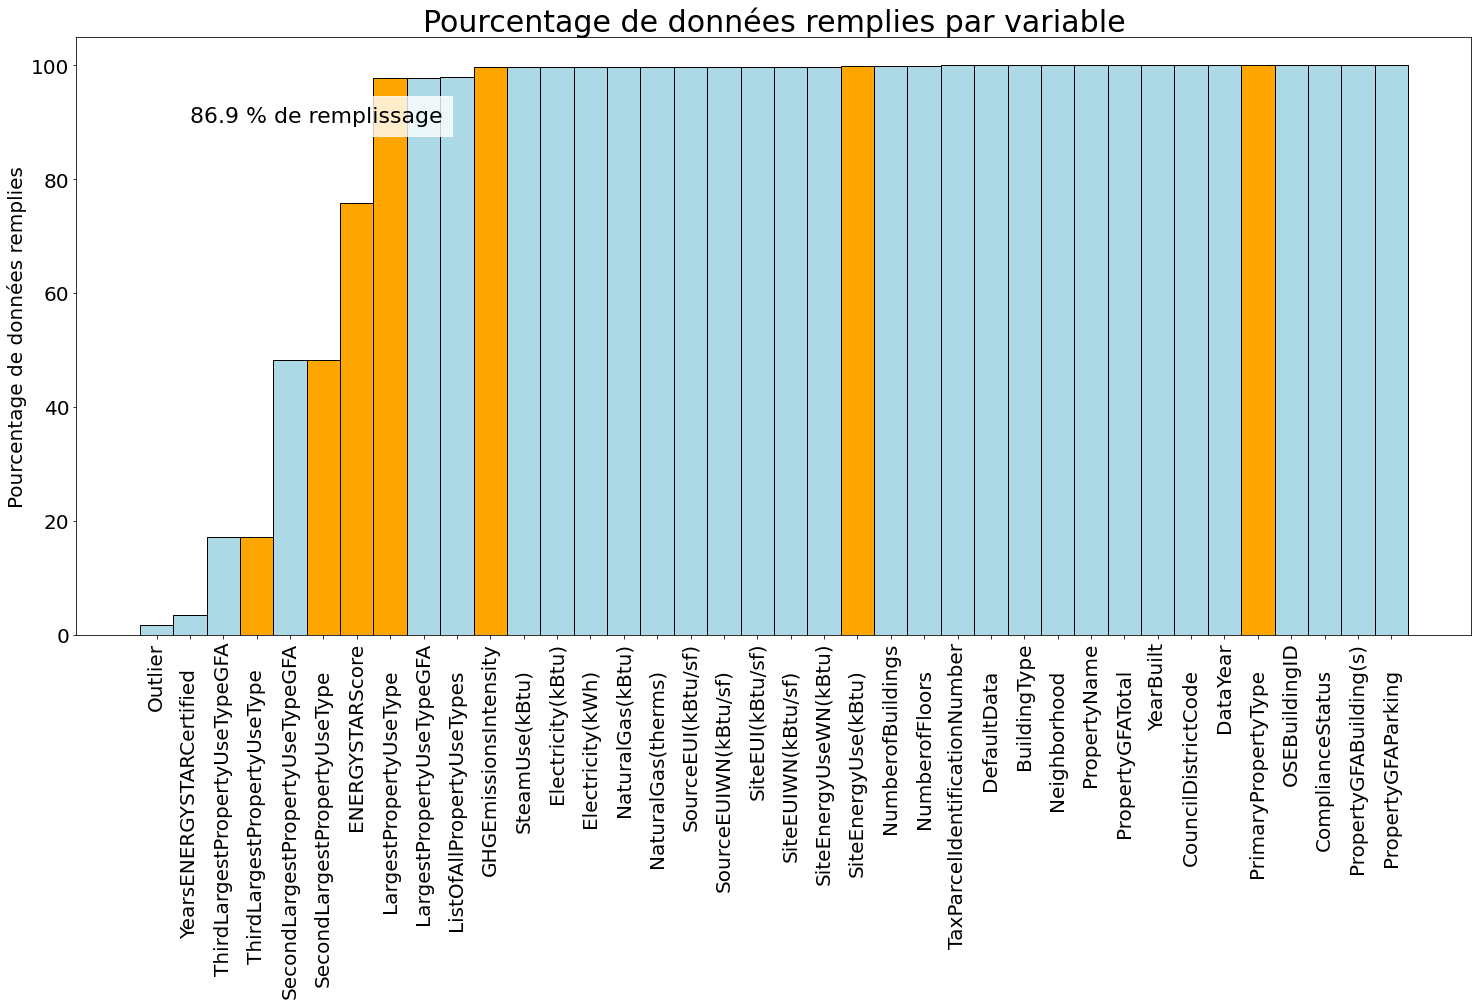

86.88559919751732


In [6]:
variables=df_common.columns.tolist()

# Liste des variables à mettre en évidence :
tokeep=['ENERGYSTARScore','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType','PrimaryPropertyType','GHGEmissionsIntensity','SiteEnergyUse(kBtu)']

remplissage_ini=[]

for col in variables:
    remplissage_ini.append( 100 - ( (df_common[col].isnull().sum()/len(df_common) * 100) )) 
# Pour chaque colonne : 100 - [ [Nb entrées vides ou nulles / longueur totale de la dataframe] * 100 ]
# ce qui donne le % de remplissage

# Création d'une DF pour faire le barplot ensuite
df_remplissage_ini=pd.DataFrame(remplissage_ini,variables,columns=['val'])    
df_remplissage_ini.sort_values(by=['val'],inplace=True)
    
my_pal = {variable: "orange" if variable in tokeep else "lightblue" for variable in df_remplissage_ini.index.tolist()}
#creation d'un dictionnaire avec les variables qui m'intéressent et que je souhaite montrer avec une couleur différente

total = df_remplissage_ini['val'].sum()/ len(df_remplissage_ini.index.tolist())
# Calcul du taux de remplissage total

# Plot :
fig, ax = plt.subplots(figsize=(25,11))
plt.bar(df_remplissage_ini.index.tolist(),df_remplissage_ini['val'],color=my_pal.values(),edgecolor='black',width=1)
plt.xticks(rotation='vertical',size=20)
for tick in ax.xaxis.get_major_ticks()[1::2]: #décalage 1 sur 2 ticks
    tick.set_pad(30)
plt.yticks(size=20)
plt.text(1,90,str(round(total,1))+" % de remplissage", fontsize = 22,bbox = dict(facecolor = 'white', alpha = 0.8, 
                                                                               edgecolor='white', pad=10.0))
plt.ylabel('Pourcentage de données remplies',size=20)
plt.title('Pourcentage de données remplies par variable',size=30)
plt.savefig("remplissagecolonnesAVANT.png", bbox_inches='tight')
plt.show()

print(total)

In [7]:
df_common.reset_index(inplace=True)
df_common.drop(columns=['index'],inplace=True)
df_common = df_common.replace(r'\n',' ', regex=True) #suppression des newlines

In [8]:
dfna=df_common[df_common['LargestPropertyUseType'].isna()] 
# liste des primary property si "largest property use" manquant

usecom = set(df_common['LargestPropertyUseType']) & set(dfna['PrimaryPropertyType'])
# types de "property type" communs avec les "property use"

notusecom = [] 
# "property uses" non-communs avec les usetype, donc à remplacer pour uniformiser

notusecom=set(dfna['PrimaryPropertyType']) - usecom
print(notusecom)


{'Large Office', 'Mixed Use Property', 'Small- and Mid-Sized Office', 'Mid-Rise Multifamily', 'SPS-District K-12', 'High-Rise Multifamily', 'Hospital', 'Low-Rise Multifamily'}


In [9]:
# creation de dict de remplacement à partir de notusecom, avec des categories de Largest Use qui correspondent
dict_nuc={'Low-Rise Multifamily':'Multifamily Housing',
          'High-Rise Multifamily':'Multifamily Housing',
          'Mid-Rise Multifamily':'Multifamily Housing',
         'SPS-District K-12':'K-12 School',
         'Large Office':'Office',
         'Small- and Mid-Sized Office':'Office',
         'Hospital':'Hospital (General Medical & Surgical)',
         'Mixed Use Property':'Other'}

# Remplacement des LargestPropertyUseType en fonction du PrimaryPropertyType
for t in df_common.index.tolist():
    rep=df_common.loc[t,'PrimaryPropertyType']
    
    if pd.isnull(df_common.loc[t,'LargestPropertyUseType']) and (df_common.loc[t,'PrimaryPropertyType'] in usecom) : 
        df_common.loc[t,'LargestPropertyUseType']=rep
        
    elif pd.isnull(df_common.loc[t,'LargestPropertyUseType']) and (df_common.loc[t,'PrimaryPropertyType'] in notusecom) :
        df_common.loc[t,'LargestPropertyUseType']=dict_nuc[rep]

In [10]:
df_common['LargestPropertyUseType'].sort_values().unique()

array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse',
       'Data Center', 'Distribution Center', 'Financial Office',
       'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
       'Laboratory', 'Library', 'Lifestyle Center',
       'Manufacturing/Industrial Plant', 'Medical Office',
       'Movie Theater', 'Multifamily Housing', 'Museum',
       'Non-Refrigerated Warehouse', 'Office', 'Other',
       'Other - Education', 'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility',
       'Other/Specialty Hospital',
       'Outpatient Rehabilitation/Physical Therapy', 'Parking',
       'Performing Arts',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)

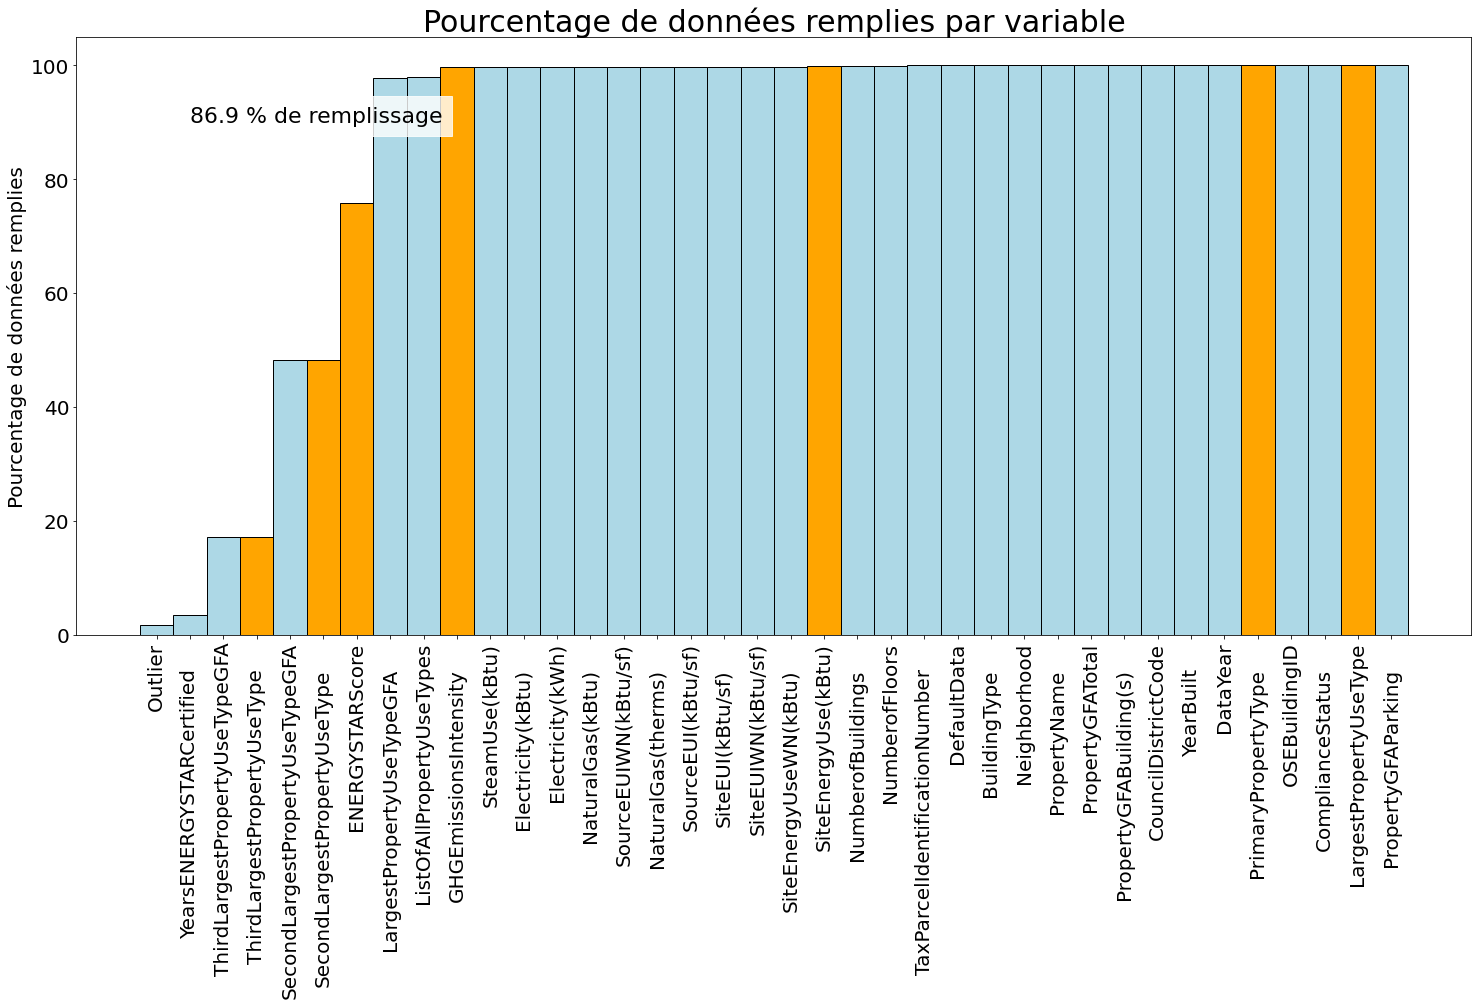

86.9467258079684


In [11]:
variables=df_common.columns.tolist()

remplissage_ini=[]
for col in variables:

    remplissage_ini.append( 100 - ( (df_common[col].isnull().sum()/len(df_common) * 100) )) 

df_remplissage_ini=pd.DataFrame(remplissage_ini,variables,columns=['val'])
    
df_remplissage_ini.sort_values(by=['val'],inplace=True)


fig, ax = plt.subplots(figsize=(25,11))
#plt.style.use('seaborn')
    
my_pal = {variable: "orange" if variable in tokeep else "lightblue" for variable in df_remplissage_ini.index.tolist()}
#creation d'un dictionnaire avec les variables que je veux highlight sur le graphe

total = df_remplissage_ini['val'].sum() / len(df_remplissage_ini.index.tolist())

plt.bar(df_remplissage_ini.index.tolist(),df_remplissage_ini['val'],color=my_pal.values(),edgecolor='black',width=1)
plt.xticks(rotation='vertical',size=20)
for tick in ax.xaxis.get_major_ticks()[1::2]: #décalage 1 sur 2 ticks
    tick.set_pad(30)
plt.yticks(size=20)
plt.text(1,90,str(round(total,1))+" % de remplissage", fontsize = 22,bbox = dict(facecolor = 'white', alpha = 0.8, 
                                                                               edgecolor='white', pad=10.0))
plt.ylabel('Pourcentage de données remplies',size=20)
plt.title('Pourcentage de données remplies par variable',size=30)
plt.savefig("remplissagecolonnesAPRES.png", bbox_inches='tight')
plt.show()

print(total)
#print(df_remplissage_ini['val'])

In [12]:
outliers=df_common[~df_common['Outlier'].isna()]

In [13]:
allppty=df_common.ListOfAllPropertyUseTypes.fillna('').tolist()

# on a des NaN sur les ListOfAllPropertyUseTypes, mais on a pu compléter le Primary ppty type
# donc on peut au moins compléter un peu

i=0
for ppty in allppty:
    if ppty=='':
        df_common.loc[i,'ListOfAllPropertyUseTypes']=df_common.loc[i,'PrimaryPropertyType']
    i=i+1

allppty=df_common.ListOfAllPropertyUseTypes.fillna('').tolist()

In [14]:
# Juste pour raccourcir les noms
df_common["ListOfAllPropertyUseTypes"].replace({"Repair Services \(Vehicle, Shoe, Locksmith, etc\)":"Repair Services",
                                                "Personal Services \(Health/Beauty, Dry Cleaning, etc\)":"Personal Services"},
                                                regex=True,inplace=True)

# Pour compléter les UseType en fonction de la liste des UseType associés au batiment
for ndx in df_common.index:
    alluse=df_common.loc[ndx,"ListOfAllPropertyUseTypes"].split(',')
    if ( len(alluse) > 1 ) and ( pd.isnull(df_common.loc[ndx,"SecondLargestPropertyUseType"]) ) :
        df_common.loc[ndx,"SecondLargestPropertyUseType"]=alluse[1]
    if ( len(alluse) > 2 ) and ( pd.isnull(df_common.loc[ndx,"ThirdLargestPropertyUseType"]) ) :
        df_common.loc[ndx,"ThirdLargestPropertyUseType"]=alluse[2]

- EUI = Energy Use Intensity (kWh)
- Source Energy = energie totale la Site Energy + incluant les pertes liées à la livraison, transmission et production de l'énergie
- Site energy = Consommation du bâtiment seule 
- GFA = Gross Floor Area (surface)
- GHGEmissionIntensity = Emission de gaz à effets de serre (GHG, Green House Gas)

### Corrélations, boxplots et PCA

In [15]:
df_common.Outlier.fillna('Not outlier',inplace=True)
# Remplissage de la colonne outlier

# Uniformisation de la casse dans la colonne Neighborhood, qui servira pour la PCA
df_common.Neighborhood=df_common.Neighborhood.str.lower()
df_common['Outlier']=df_common.Outlier.str.lower()

In [16]:
# Liste de variables pour PCA / correl etc
ForPCA_all=['PropertyGFATotal', 
       'PropertyGFAParking', 'NaturalGas(therms)',
       'NumberofFloors', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)', 'NumberofBuildings',
       'SteamUse(kBtu)','LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
       'PropertyGFABuilding(s)', 'Electricity(kWh)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)']

# sans redondance (pas besoin de 2 variables NaturalGas par ex.)
ForPCA=['PropertyGFATotal', 'ENERGYSTARScore',
       'PropertyGFAParking',
       'NumberofFloors', 'Electricity(kBtu)',
       'NaturalGas(kBtu)',  'NumberofBuildings',
       'SteamUse(kBtu)', 'SiteEUI(kBtu/sf)',
        'SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','GHGEmissionsIntensity','Neighborhood']

df_pca=df_common[ForPCA].dropna().reset_index(drop=True)
df_pca.shape

(5090, 13)

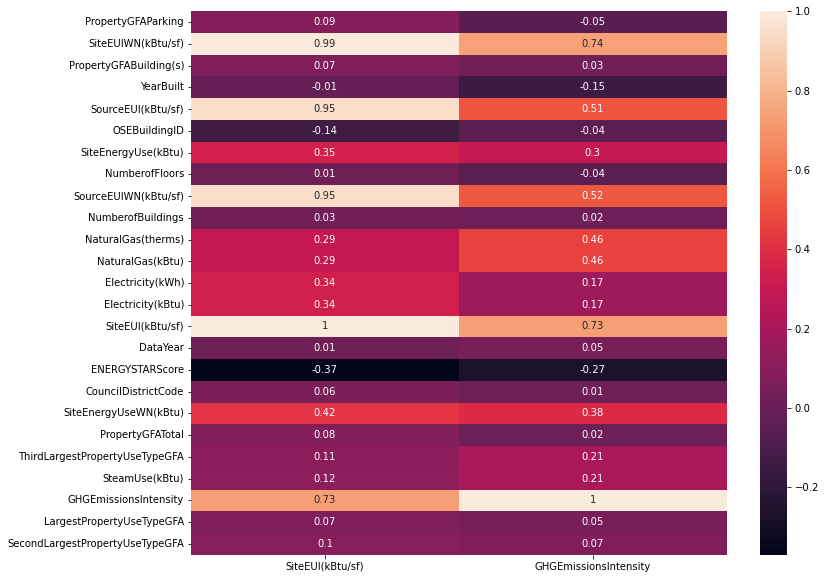

In [17]:
#Correlations sur les targets pour éliminer les variables trop corrélées
corel = df_common.corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corel[['SiteEUI(kBtu/sf)','GHGEmissionsIntensity']], annot=True)
plt.savefig("correlationmatrix_TARGETS.png",bbox_inches='tight')

In [18]:
df_common=df_common.drop(columns=['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)'])
ForPCA_all.remove('SiteEUIWN(kBtu/sf)')
ForPCA_all.remove('SourceEUIWN(kBtu/sf)')

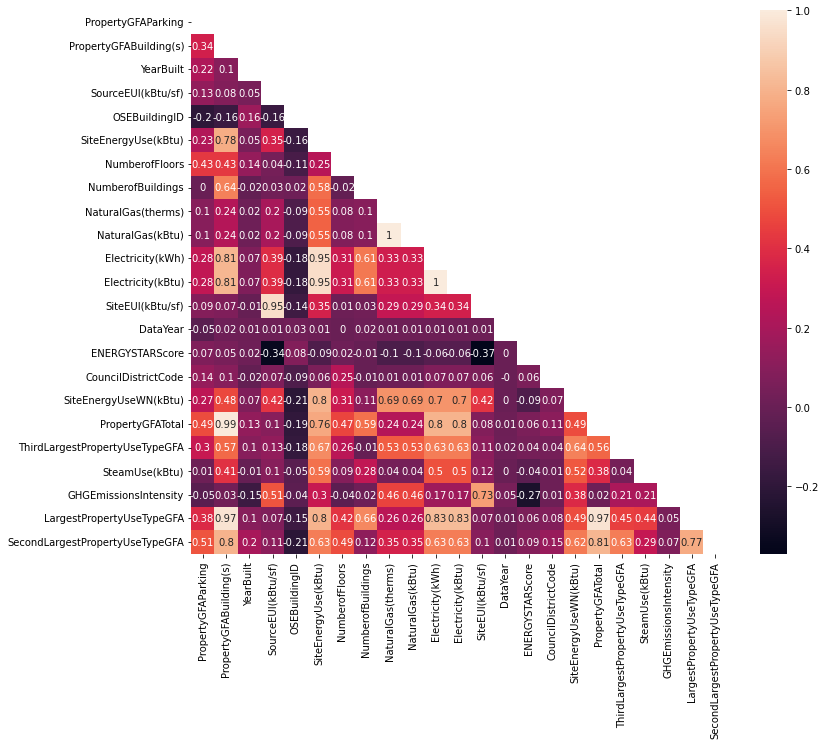

In [19]:
# Matrice de corrélation sur toutes les variables
# Permet de faire un premier tri et de voir quelles variables sont très très corrélées entre elles
# Et donc d'en supprimer pour la suite
corel = df_common.corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
mk = np.triu(np.ones_like(corel, dtype=bool)) #masquer le triangle sup
sns.heatmap(corel, annot=True, mask=mk)
plt.savefig("correlationmatrix_all.png",bbox_inches='tight')

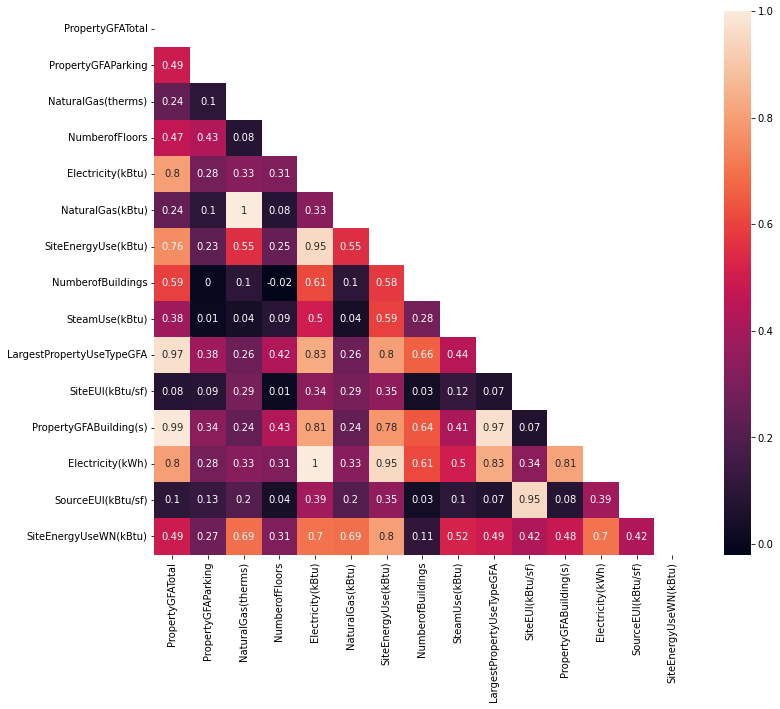

In [20]:
# Matrice de corrélation après premier tri
corel = df_common[ForPCA_all].corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
mk = np.triu(np.ones_like(corel, dtype=bool)) #masquer le triangle sup
sns.heatmap(corel, annot=True, mask=mk)
plt.savefig("correlationmatrix.png",bbox_inches='tight')

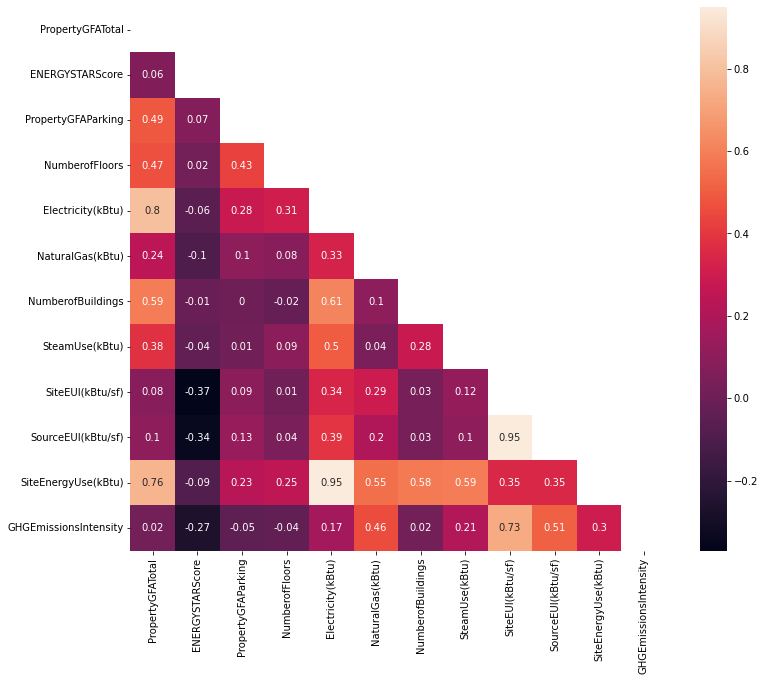

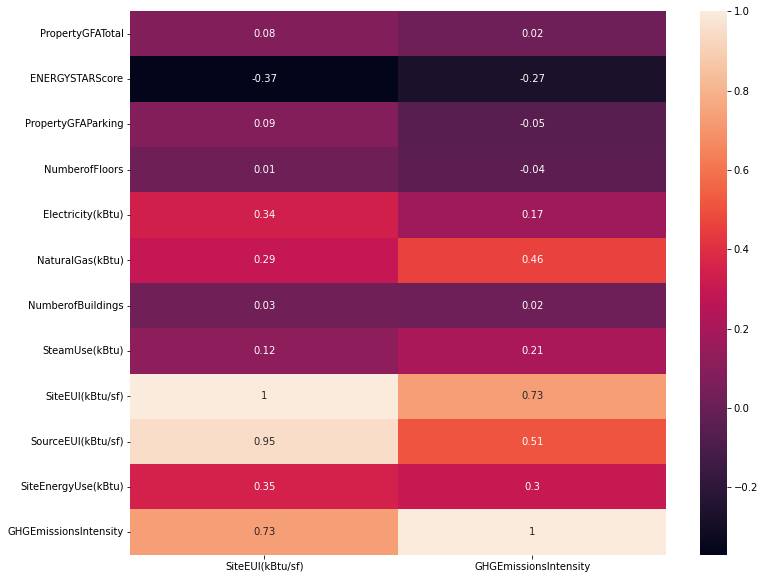

In [21]:
# Matrice de corrélation après 2e tri
corel = df_common[ForPCA].corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
mk = np.triu(np.ones_like(corel, dtype=bool)) #masquer le triangle sup
sns.heatmap(corel, annot=True, mask=mk)
plt.savefig("correlationmatrix_reduced.png",bbox_inches='tight')

#Correlations sur les targets pour éliminer les variables trop corrélées
corel = df_common[ForPCA].corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corel[['SiteEUI(kBtu/sf)','GHGEmissionsIntensity']], annot=True)
plt.savefig("correlationmatrix_TARGETS_clean.png",bbox_inches='tight')

### Boxplots

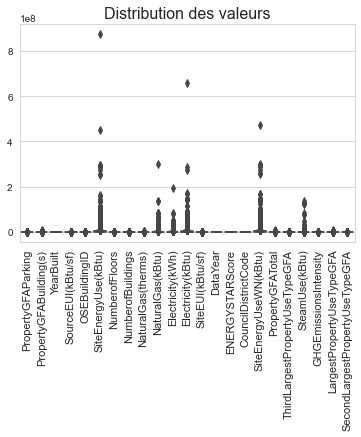

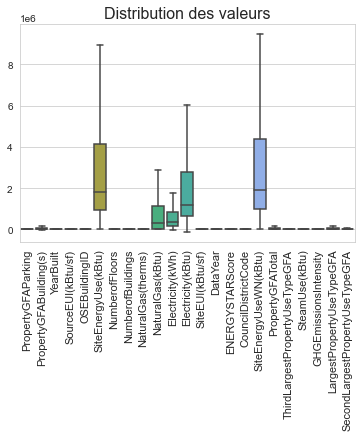

In [22]:
# Boxplots sur données brutes,sans transformation
sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax.set_title('Distribution des valeurs',size=16)  
plt.xticks(rotation='vertical',size=11)
fig=sns.boxplot(data=df_common,showfliers=True)
plt.savefig("boxplot_fliers.png", bbox_inches='tight') 

sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax.set_title('Distribution des valeurs',size=16)  
plt.xticks(rotation='vertical',size=11)
fig=sns.boxplot(data=df_common,showfliers=False)
plt.savefig("boxplot_nofliers.png", bbox_inches='tight')


C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


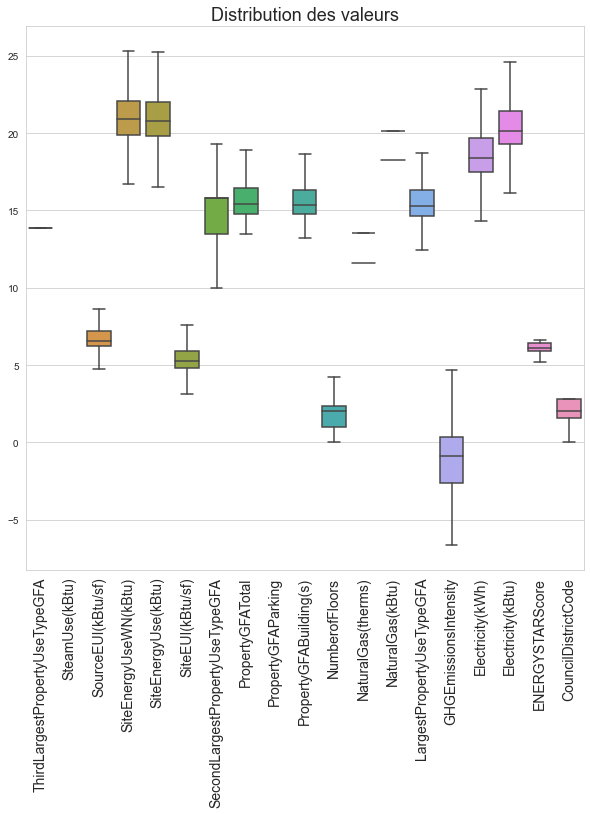

In [23]:
# Log-transformation des variables numériques pour plus de lisibilité:

num=[]

for col in df_common.columns:
    if is_numeric_dtype(df_common[col]):
        num.append(col)
# Récupération des colonnes de type "numeric" pour faire les boxplot

df_commonNum=df_common[num].drop(columns=["YearBuilt","DataYear","NumberofBuildings","OSEBuildingID"])

# Drop des colonnes pas pertinentes pour le boxplot et création de la dataframe

df_commonNum.fillna(df_commonNum.dropna().mean(),inplace=True)
df_commonNum.sort_index(axis=1, ascending=False,inplace=True)
# Pour ne pas supprimer les valeurs manquantes et garder le plus de données possibles : 
# replacement des valeurs par la moyenne (juste pour le boxplot)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Distribution des valeurs',size=18)  
plt.xticks(rotation='vertical',size=14)
fig=sns.boxplot(data=np.log2(df_commonNum),showfliers=False)
plt.savefig("boxplot_Log2_Nofliers.png", bbox_inches='tight')
    

C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


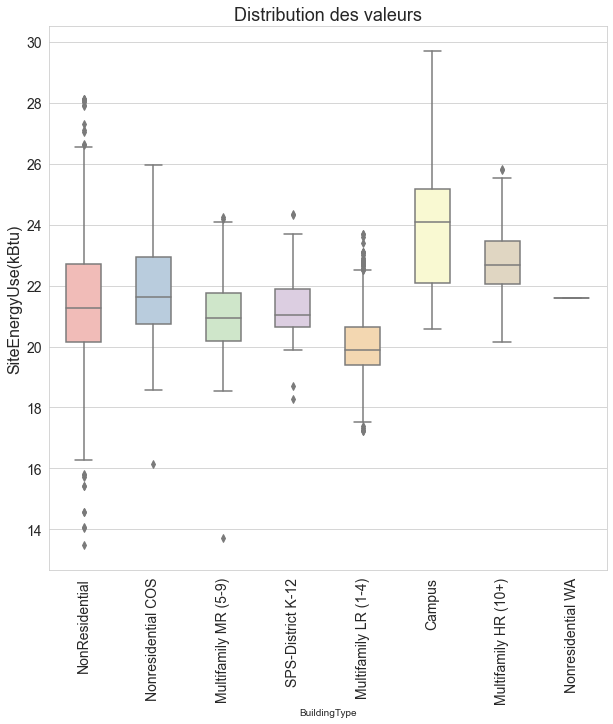

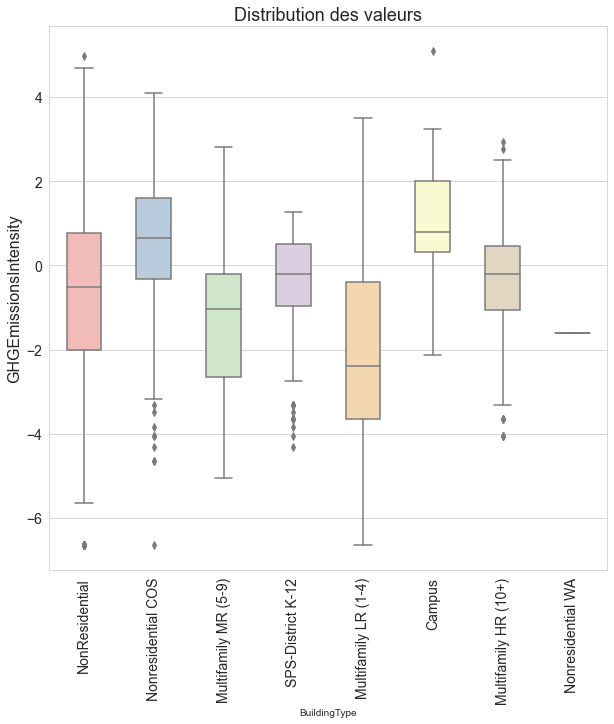

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='BuildingType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.yticks(size=14)
plt.ylabel('SiteEnergyUse(kBtu)',size=16)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_BuildingType_Target1.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='BuildingType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.ylabel('GHGEmissionsIntensity',size=16)
plt.yticks(size=14)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_BuildingType_Target2.png", bbox_inches='tight')

C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


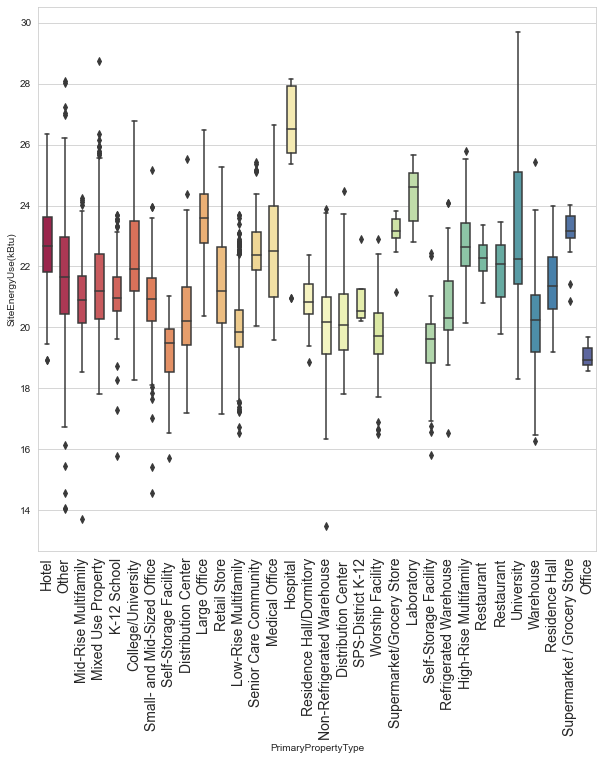

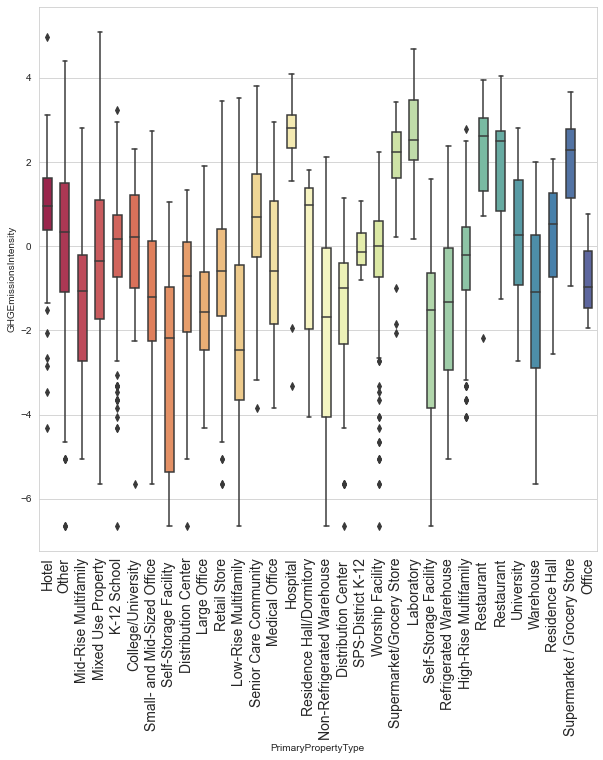

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='PrimaryPropertyType', data=df_common, palette="Spectral",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.savefig("boxplot_PrimaryPpty.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='PrimaryPropertyType', data=df_common, palette="Spectral",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.savefig("boxplot_PrimaryPpty.png", bbox_inches='tight')

C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camille.besancon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3963: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
C:\Users\camille.besancon\Anaconda3\lib

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]),
 [Text(0, 0, 'Hotel'),
  Text(1, 0, 'Police Station'),
  Text(2, 0, 'Other - Entertainment/Public Assembly'),
  Text(3, 0, 'Multifamily Housing'),
  Text(4, 0, 'Library'),
  Text(5, 0, 'Fitness Center/Health Club/Gym'),
  Text(6, 0, 'Social/Meeting Hall'),
  Text(7, 0, 'Courthouse'),
  Text(8, 0, 'Other'),
  Text(9, 0, 'K-12 School'),
  Text(10, 0, 'College/University'),
  Text(11, 0, 'Automobile Dealership'),
  Text(12, 0, 'Office'),
  Text(13, 0, 'Self-Storage Facility'),
  Text(14, 0, 'Distribution Center'),
  Text(15, 0, 'Retail Store'),
  Text(16, 0, 'Senior Care Community'),
  Text(17, 0, 'Medical Office'),
  Text(18, 0, 'Hospital (General Medical & Surgical)'),
  Text(19, 0, 'Museum'),
  Text(20, 0, 'Repair Services (Vehi

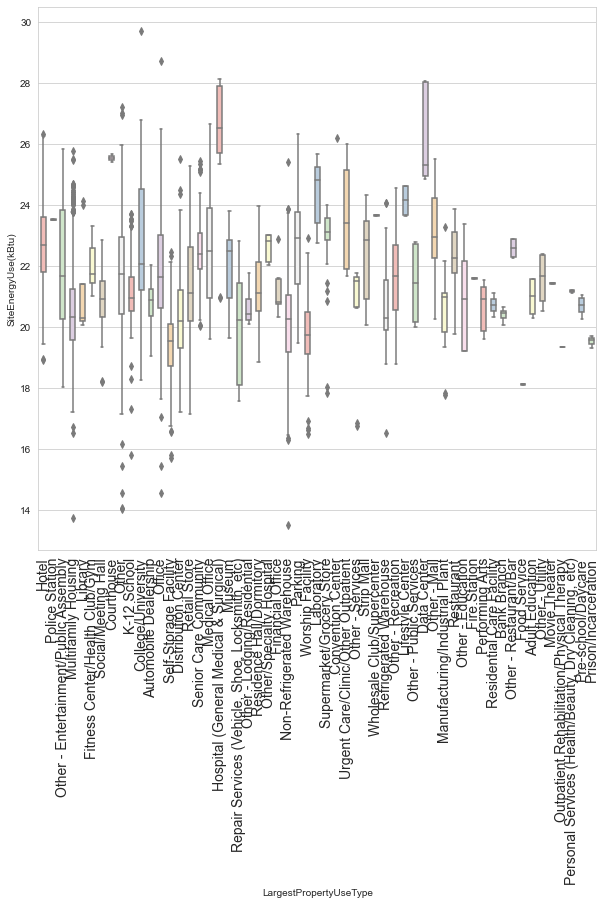

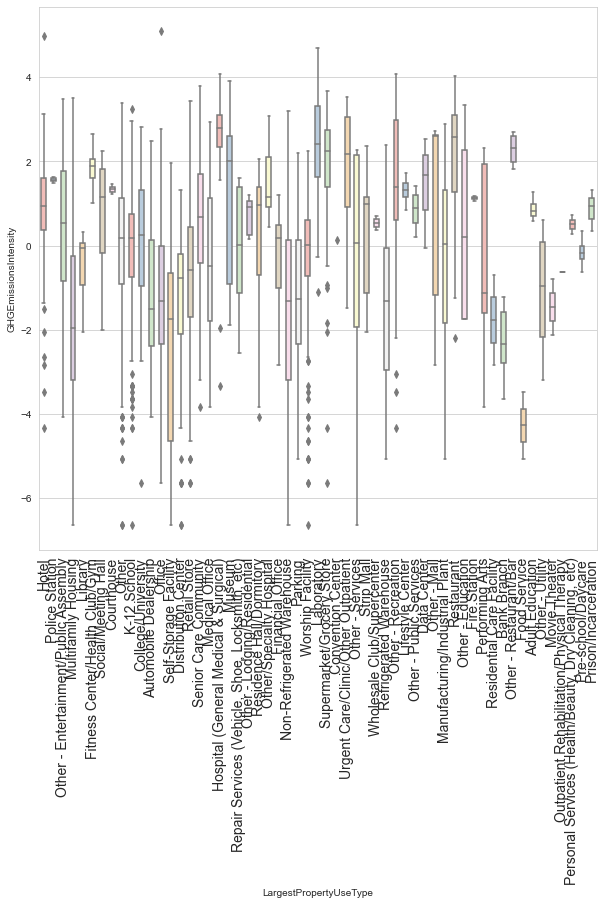

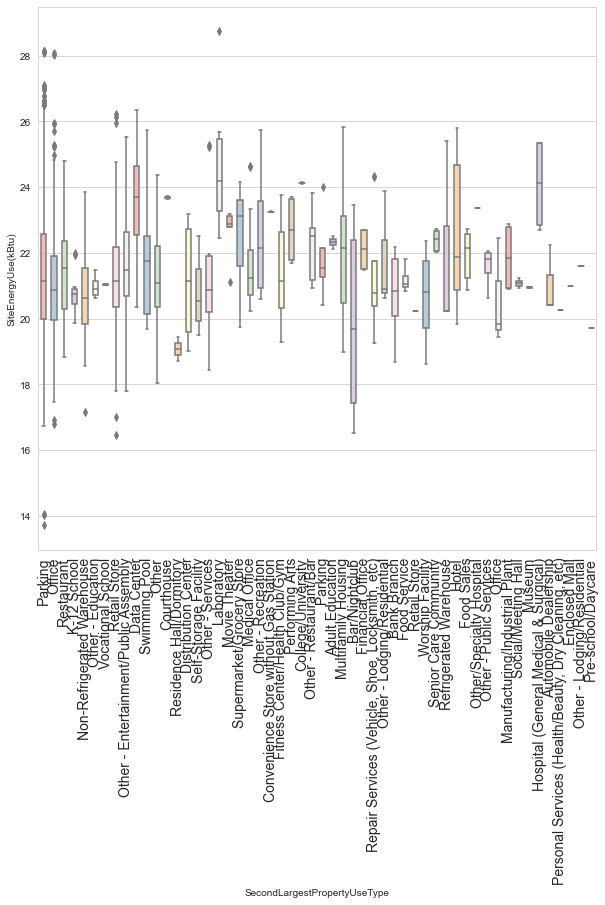

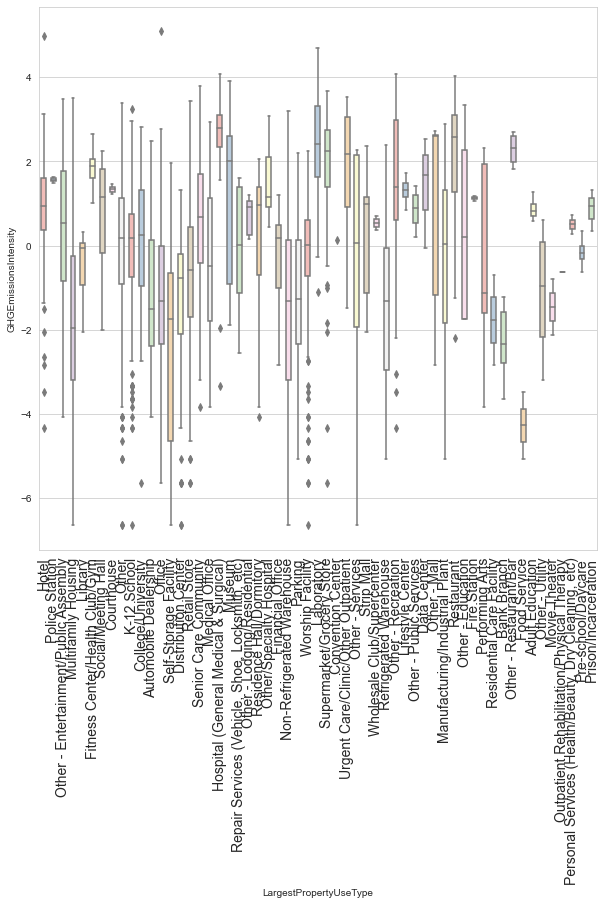

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='LargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)

fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='LargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)

fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='SecondLargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)

fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='LargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)

### ACP sur données de départ

In [27]:

x_prenorm=df_pca.iloc[:,:-1].drop(columns=['ENERGYSTARScore']) #selection des features pour la PCA

# Normalisation entre 0 et 1
scaler = MinMaxScaler() 
x = scaler.fit_transform(x_prenorm)
x=np.log2(x+1)

samples=df_pca.index.tolist() #samples=index utilisé ensuite pour la couleur des points sur le graphique de l'acp

varz=df_pca.iloc[:,:-1].drop(columns=['ENERGYSTARScore']).columns.tolist() #Variables utilisées pour l'ACP
# Je retire l'ESC car je veux voir les composantes principales sans ESC en prévision de la construction des modèles

data_norm=pd.DataFrame(x,columns=varz) #je refais un df avec mon ndarray + les noms de colonnes
data_norm.to_csv(r'normalized_data_pca.csv')

pca_test= PCA()
principalComponents_test = pca_test.fit_transform(x) #ndarray

principal_test_Df = pd.DataFrame(data = principalComponents_test)

###########################
print(pca_test.explained_variance_ratio_*100)
principal_test_Df.to_csv(r'pca_Starsore.csv')
print(principal_test_Df.columns.tolist())

[4.75465273e+01 2.43564488e+01 9.44865659e+00 6.69325389e+00
 4.56208002e+00 2.68326445e+00 2.35204338e+00 1.75123932e+00
 4.67121240e-01 1.37480342e-01 1.88466201e-03]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<Figure size 640x480 with 0 Axes>

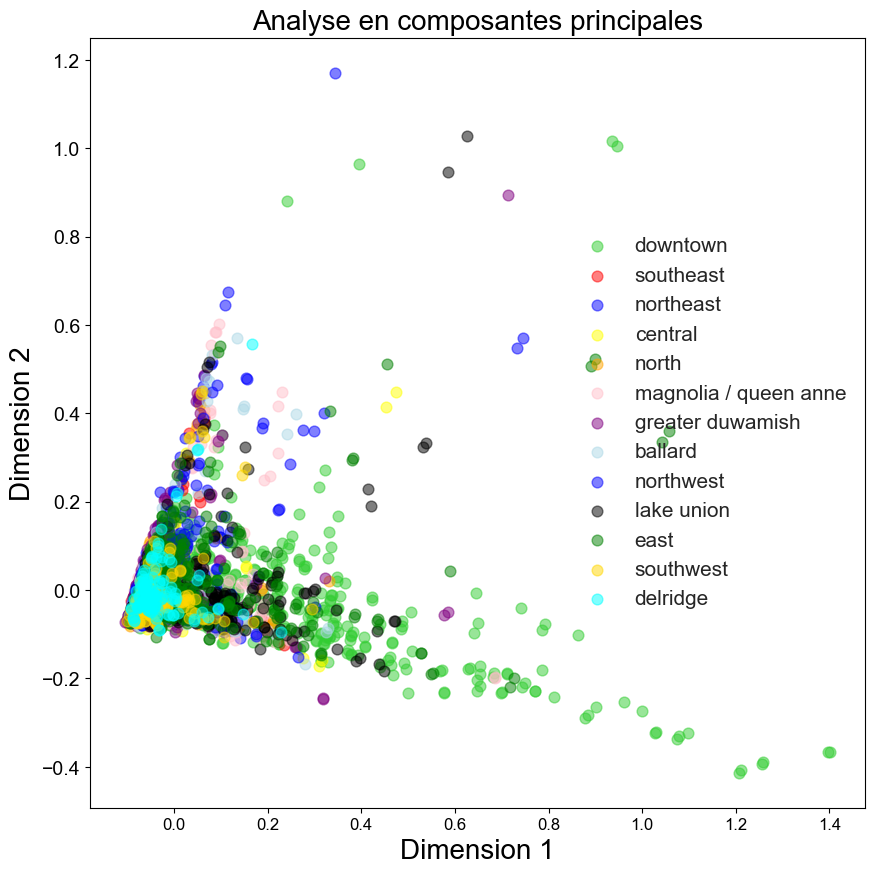

In [28]:
# Graphe PCA

targets=df_pca.Neighborhood.unique().tolist()
# Targets = la variable catégorielle avec laquelle je vais colorer le scatter plot

bildingz=df_pca.index.tolist()

plt.rcParams.update(plt.rcParamsDefault)
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Dimension 1',fontsize=20)
plt.ylabel('Dimension 2',fontsize=20)
plt.title("Analyse en composantes principales",fontsize=20)
colors=['limegreen','red','blue','yellow','orange','pink','purple','lightblue','blue','black','green','gold','cyan']


plt.style.use('seaborn-whitegrid')

# Pour chaque catégorie, on attribue une couleur et on dessine les points
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['Neighborhood'] == target
    
    plt.scatter(principal_test_Df.loc[indicesToKeep, 0]
            , principal_test_Df.loc[indicesToKeep, 1]
            , c = color,alpha=0.5, s=60)

plt.legend(targets,prop={'size': 15})

plt.savefig("PCA_STarScore.png")
plt.show()
plt.close()

C:\Users\CAMILL~1.BES\AppData\Local\Temp/ipykernel_22960/4087907716.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbx_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('PCA_3D.png',bbx_inches='tight')


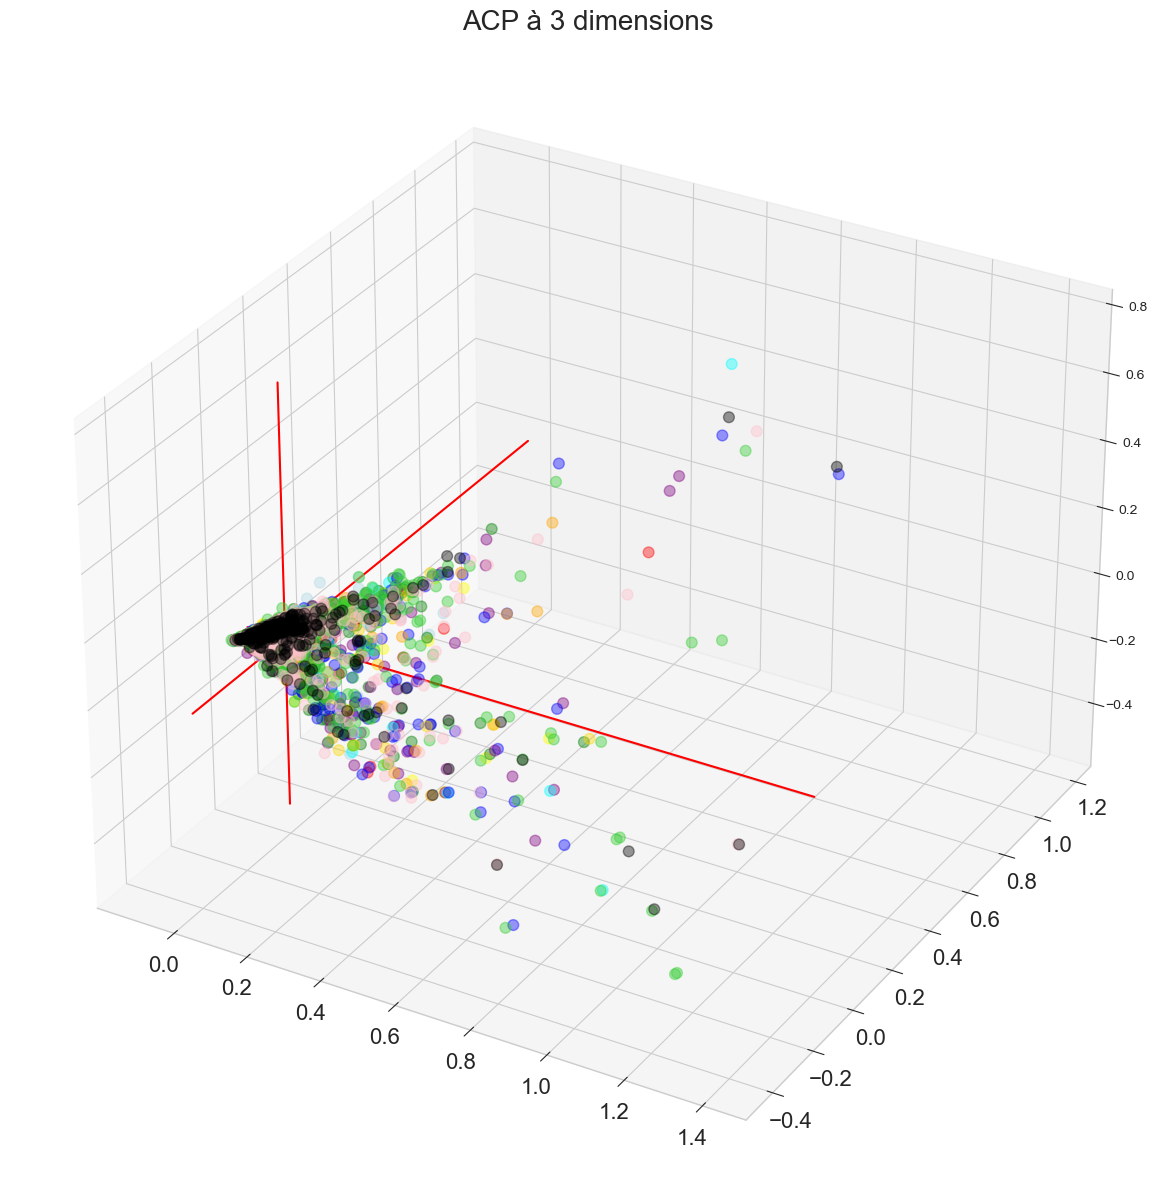

In [29]:
#targets = grpes #liste des grpes cibles (malades, pas malades...)
colors=['limegreen','red','blue','yellow','orange','pink','purple','lightblue','blue','black','green','gold','cyan','brown']

df_common['Neighborhood']=pd.Categorical(df_common['Neighborhood'])
my_color=df_common['Neighborhood'].cat.codes

fig=plt.figure(figsize=(15,15))
#plt.ylim(-10,20)
#plt.xlim(-15,20)

ax = fig.add_subplot(111, projection='3d')

for target, color in zip(targets,colors):
    indicesToKeep = df_common['Neighborhood'] == target #colonne des grpes cibles #NOT COHORT
    ax.scatter(principal_test_Df.loc[indicesToKeep,0], principal_test_Df.loc[indicesToKeep,1],
           principal_test_Df.loc[indicesToKeep,2], c=color, cmap="Set2_r", s=60,alpha=0.4)

 # make simple, bare axis lines through space:
xAxisLine = ((min(principal_test_Df[0]), 
              max(principal_test_Df[0])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(principal_test_Df[1]), 
                      max(principal_test_Df[1])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(principal_test_Df[2]), 
                             max(principal_test_Df[2])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ACP à 3 dimensions",fontsize=20)

#colors = {'HC':'limegreen', 'msAD':'orange','miAD':'r','PDD':'darkblue', 'DLB':'lightblue','FTD':'gray','CBD':'skyblue', 'PSP':'b'}
colors={'limegreen':'Downtown','red':'Southeast','blue':'Northeast','yellow':'Central',
        'orange':'North','pink':'Magnolia / Queen Anne','purple':'greater duwamish','lightblue':'ballard',
        'blue':'northwest','black':'lake union','green':'east','gold':'southwest','cyan':'delridge'}

#labels = list(colors.keys())
#rect = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#plt.legend(rect, labels,fontsize=20)

plt.savefig('PCA_3D.png',bbx_inches='tight')
# label the axes
plt.show()

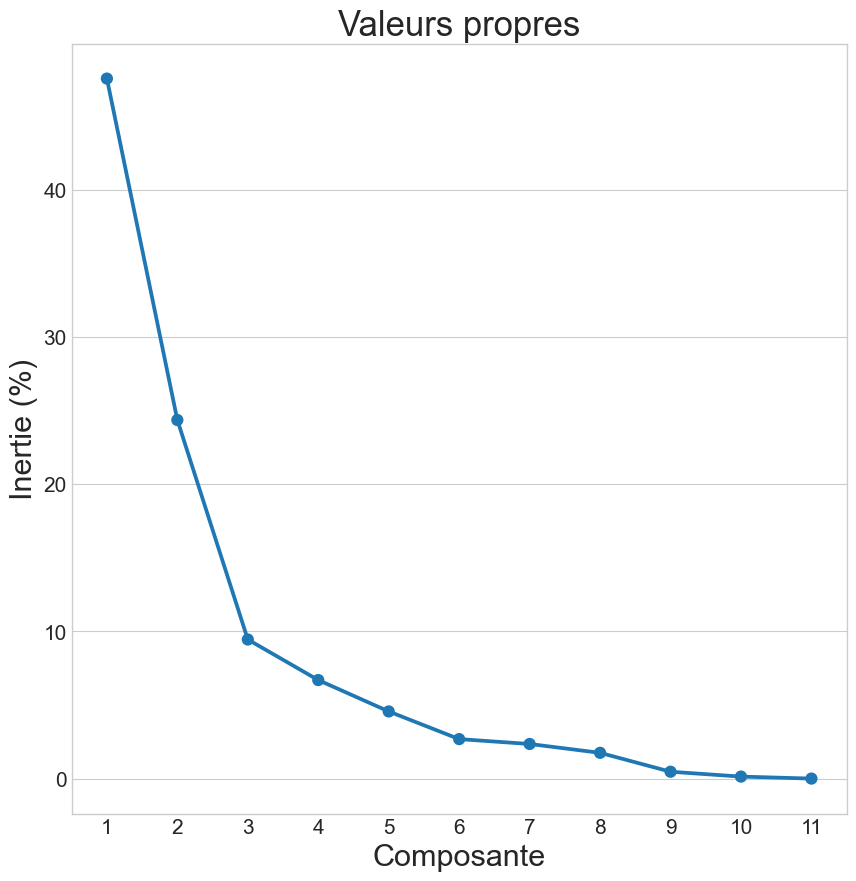

<Figure size 640x480 with 0 Axes>

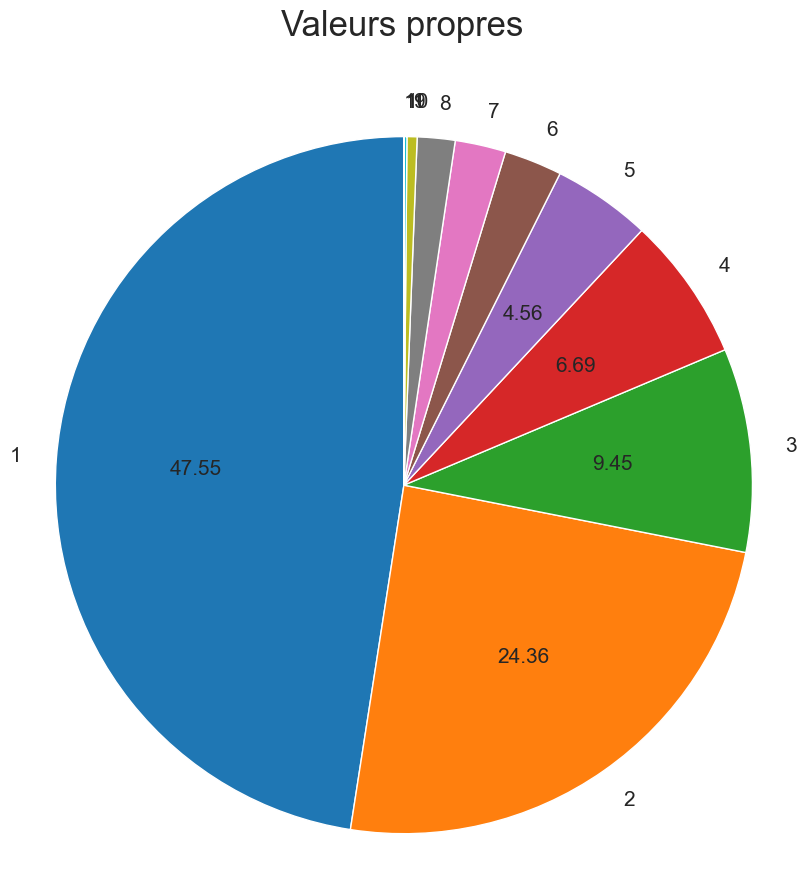

In [30]:
PCs = pca_test.components_

np.arange(PCs.shape[1])

indx = np.arange(1, PCs.shape[1]+1)
(fig, ax) = plt.subplots(figsize=(10, 10))
sns.set_style("whitegrid")
sns.pointplot(x=indx, y=pca_test.explained_variance_ratio_ * 100)
#ax.set_xticks(indx)
ax.set_xticklabels(indx,fontsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Composante',size=22)
ax.set_ylabel('Inertie (%)',size=22)
#ax.set_title('testplot')
plt.title("Valeurs propres",size=25)
plt.savefig("Composantes_éboulis.png")
plt.show()


def reautopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''

labels = indx
sizes = pca_test.explained_variance_ratio_ * 100

plt.figure()
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct=reautopct,
        shadow=False, startangle=90,textprops={'fontsize': 15})
plt.title("Valeurs propres",size=25, y=1.08)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("Piechart_valeurspropres.png")
plt.show()

Cyan = quartier Delridge, c'est un quartier résidentiel -> consommation d'énergie moins "intense" et nombres d'étages qui sera moins élevé, contrairement au vert (Downtown), centre ville donc buildings + hauts type quartiers d'affaire aux états unis, des parkings, donc des grosses consommations électriques

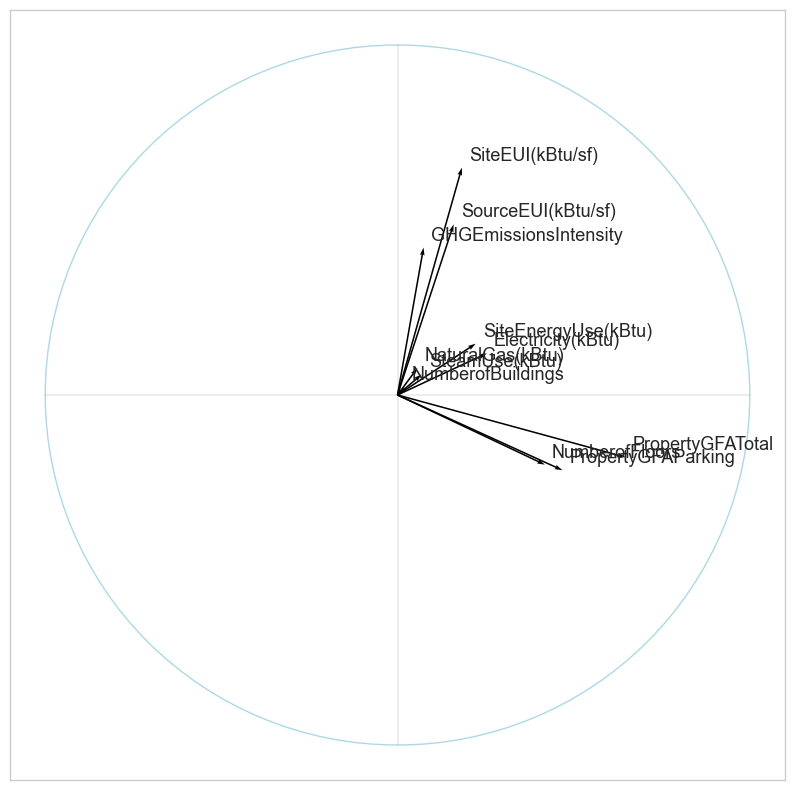

In [31]:
pca_test.n_components_

fig = plt.figure(figsize=(10,10))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1, width=0.002,cmap='tab20c')

feature_names = np.arange(PCs.shape[1])
for i in feature_names:
    txt=df_pca.drop(columns=['ENERGYSTARScore']).columns.values[i]
    plt.text(PCs[0, i] + 0.02,
             PCs[1, i] + 0.02,
             txt,size=13)

sns.set_style("whitegrid")
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='lightblue')
plt.gca().add_artist(circle)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

plt.xticks([])
plt.yticks([])
plt.hlines(xmin=-1,xmax=1,y=0,color='k',linewidths=0.1)
plt.vlines(ymin=-1,ymax=1,x=0,color='k',linewidths=0.1)

plt.savefig("circle_SansStarScore.png")
plt.show()


## feature engineering

Objectif : "casser" les relations linéaires entre les variables en préparation de la construction des modèles

In [32]:

ForPCA.append('YearBuilt')
df_pca=df_common[ForPCA].dropna().reset_index(drop=True)

df_pca["EnergyLoss"]=(df_pca["SourceEUI(kBtu/sf)"])-(df_pca["SiteEUI(kBtu/sf)"])
df_pca["PercentSteam"]=df_pca["SteamUse(kBtu)"]/(df_pca["Electricity(kBtu)"]+df_pca["NaturalGas(kBtu)"]+df_pca["SteamUse(kBtu)"]+0.01)
df_pca["PercentElec"]=df_pca["Electricity(kBtu)"]/(df_pca["Electricity(kBtu)"]+df_pca["NaturalGas(kBtu)"]+df_pca["SteamUse(kBtu)"]+0.01)
df_pca["PercentGas"]=df_pca["NaturalGas(kBtu)"]/(df_pca["Electricity(kBtu)"]+df_pca["NaturalGas(kBtu)"]+df_pca["SteamUse(kBtu)"]+0.01)

df_pca["LossPerFloor"]=df_pca["EnergyLoss"]/(df_pca['NumberofFloors']+0.01)

df_pca["Age"]=2022-df_pca['YearBuilt']

todrop=["Electricity(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)",
        "Neighborhood","SiteEnergyUse(kBtu)",'YearBuilt',
        "SiteEUI(kBtu/sf)",'SourceEUI(kBtu/sf)',
       'ENERGYSTARScore',"EnergyLoss"] #selection des features pour la PCA


In [33]:
df_pca.drop(todrop, axis=1)

,PropertyGFATotal,PropertyGFAParking,NumberofFloors,NumberofBuildings,GHGEmissionsIntensity,PercentSteam,PercentElec,PercentGas,LossPerFloor,Age
0,88434,0,12.0,1.0,2.64,0.289767,0.527984,0.182249,7.876769,95
1,103566,15064,11.0,1.0,2.38,0.000000,0.467468,0.532532,8.801090,26
2,961990,0,41.0,1.0,1.92,0.268832,0.680440,0.050728,3.562546,53
3,61320,0,10.0,1.0,31.38,0.830995,0.098090,0.070915,17.572428,96
4,119890,12460,18.0,1.0,4.02,0.000000,0.409070,0.590930,6.035536,42
...,...,...,...,...,...,...,...,...,...,...
5085,208136,58818,7.0,1.0,0.47,0.000000,0.559873,0.440127,3.680457,7
5086,20246,2580,4.0,1.0,0.93,0.000000,0.632940,0.367060,15.311720,8
5087,13661,0,1.0,1.0,0.26,0.000000,1.000000,0.000000,77.920793,70
5088,15398,0,1.0,1.0,0.51,0.000000,0.715652,0.284348,38.514849,62


### Préparation du OneHotEncoder pour les PropertyUsetype

In [ ]:
# Visualisation de la proportion de chaque type

# "nettoyage" des chaines de caractère
df_common['LargestPropertyUseType']=df_common['LargestPropertyUseType'].str.replace('\(','').str.replace('\)','').str.replace('\/',' ').str.replace('\-',' ') 
df_common['LargestPropertyUseType']=df_common['LargestPropertyUseType'].str.replace('Other ','')
df_common['LargestPropertyUseType']=df_common['LargestPropertyUseType'].str.replace('  ','')

# Calcul du pourcentage associé à chaque type
x=df_common['LargestPropertyUseType'].value_counts()/len(df_common['LargestPropertyUseType'])*100

# Bar plot
fig, ax = plt.subplots(figsize=(15,11))
plt.title('Property use types',size=20)
plt.bar(x.index, x.values, align='center')
plt.xticks(rotation='vertical',size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('usetype.png',bbox_inches='tight')
plt.show()
plt.close()

C:\Users\CAMILL~1.BES\AppData\Local\Temp/ipykernel_22960/884344120.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_common['LargestPropertyUseType']=df_common['LargestPropertyUseType'].str.replace('\(','').str.replace('\)','').str.replace('\/',' ').str.replace('\-',' ')


In [ ]:
# Encoding - tout ce qui est < 2% va dans la catégorie "Other"
autre=[]
for bat in x.index:
    if x[bat]<2: autre.append(bat)

for au in autre:
    df_common['LargestPropertyUseType']=df_common['LargestPropertyUseType'].replace(au,'Other')
    
fig, ax = plt.subplots(figsize=(15,11))
plt.title('Property use types pour encodage',size=20)
fig=df_common['LargestPropertyUseType'].value_counts().plot.bar()
plt.xticks(fontsize=30)
#plt.ylabel(fontsize=20)
plt.show()
plt.savefig('usetype_apres.png',bbox_inches='tight')
plt.close()

In [ ]:
# Encoding - tout ce qui est < 2% va dans la catégorie "Other"
df_common['SecondLargestPropertyUseType']=df_common['SecondLargestPropertyUseType'].str.replace('\(','').str.replace('\)','').str.replace('\/',' ').str.replace('\-',' ') 
df_common['SecondLargestPropertyUseType']=df_common['SecondLargestPropertyUseType'].str.replace('Other ','')
df_common['SecondLargestPropertyUseType']=df_common['SecondLargestPropertyUseType'].str.replace('  ','')

# Calcul du pourcentage associé à chaque type
x=df_common['SecondLargestPropertyUseType'].value_counts()/len(df_common['SecondLargestPropertyUseType'])*100

autre=[]
for bat in x.index:
    if x[bat]<1: autre.append(bat)

for au in autre:
    df_common['SecondLargestPropertyUseType']=df_common['SecondLargestPropertyUseType'].replace(au,'Other')
    
fig, ax = plt.subplots(figsize=(15,11))
plt.title('Property use types pour encodage',size=20)
fig=df_common['SecondLargestPropertyUseType'].value_counts().plot.bar()
plt.xticks(fontsize=30)
#plt.ylabel(fontsize=20)
plt.show()
plt.savefig('secondusetype_apres.png',bbox_inches='tight')
plt.close()

### Outliers et valeurs extrêmes
Visualisation graphique des fréquences associées aux variables que l'on souhaite prédire (site energy use et GHG Emissions). Les valeurs "extrêmes" trop peu représentées sont retirées

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure()
plt.figure(figsize=(15,15))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Site Energy Use Intensity (log2)',fontsize=20)
plt.ylabel('Fréquence',fontsize=20)
plt.title("Consommation d'énergie",fontsize=20)

log=df_common['SiteEUI(kBtu/sf)'].dropna()
#log=np.log2(log[log>0])
counts, edges, mpl = plt.hist(log,bins=np.arange(13,30))

for count, pl in zip(counts,mpl):
    
    plt.annotate(str(int(count)), xy=(pl.get_x(), pl.get_height()+20),fontsize=15)
    
plt.savefig("histogramme_EnergyUse",bbox_inches='tight')
plt.show()
plt.close()


#######################################################

plt.figure()
plt.figure(figsize=(15,15))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Emissions de gaz à effet de serre (log2)',fontsize=20)
plt.ylabel('Fréquence',fontsize=20)
plt.title("Emissions",fontsize=20)

log=df_common['GHGEmissionsIntensity'].dropna()
log=np.log2(log[log>0])
counts, edges, plot = plt.hist(log)

for count, pl in zip(counts,plot):
    
    plt.annotate(str(int(count)), xy=(pl.get_x(), pl.get_height()+20),fontsize=15)
    
plt.savefig("histogramme_emissions",bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
df_ml=df_pca.join(df_common[['LargestPropertyUseType', 'SecondLargestPropertyUseType','BuildingType','Outlier']])
todrop.remove('SiteEUI(kBtu/sf)')
todrop.remove('ENERGYSTARScore')
df_ml.drop(columns=todrop,inplace=True)
df_ml.reset_index(drop=True)


#df_ml=df_ml.loc[(df_ml['SiteEUI(kBtu/sf)']>2**18) & (df_ml['SiteEUI(kBtu/sf)']<2**26)]
df_ml=df_ml.loc[(df_ml['GHGEmissionsIntensity']>2**-5) & (df_ml['GHGEmissionsIntensity']<2**3)]
df_ml=df_ml[df_ml['Outlier']=='not outlier']
df_ml.drop(columns=['Outlier'],inplace=True)
df_ml.to_csv('DataML.csv',index=False)
df_ml.shape

In [ ]:
#Correlations des var. finales par rapport aux targets
corel = df_ml.corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corel[['SiteEUI(kBtu/sf)','GHGEmissionsIntensity']], annot=True)

In [ ]:
todrop

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='LargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.yticks(size=14)
plt.ylabel('SiteEnergyUse(kBtu)',size=16)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_Largetsppty_Target1.png", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='LargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.yticks(size=14)
plt.ylabel('GHGEmissionsIntensity',size=16)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_Largetsppty_Target2.png", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['SiteEnergyUse(kBtu)']), x='SecondLargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.ylabel('SiteEnergyUse(kBtu)',size=16)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_2dLargetsppty_Target1.png", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(10,10))
fig=sns.boxplot(y=np.log2(df_common['GHGEmissionsIntensity']), x='SecondLargestPropertyUseType', data=df_common, palette="Pastel1",width=0.5)
plt.xticks(rotation='vertical',size=14)
plt.ylabel('GHGEmissionsIntensity',size=16)
ax.set_title('Distribution des valeurs',size=18)  
plt.savefig("boxplot_2dLargetsppty_Target2.png", bbox_inches='tight')